# Serial Position Cell Analysis

Analyze TH data for serial positon cells. 

Cells of interest:
- 74 looks to be a serial position cell (not sure which session...)

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path
from collections import Counter

import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import zscore_to_surrogates, compute_empirical_pvalue
from spiketools.plts.space import plot_positions
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes
from spiketools.plts.data import plot_bar
from spiketools.utils import restrict_range
from spiketools.utils.data import get_value_by_time, get_value_by_time_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions
from target import compute_serial_position_fr

# Settings

In [5]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/')

In [6]:
# Define subject information
task = 'THO'
subj = 'wv001'
session = 2

In [7]:
# Shuffle Settings
shuffle_approach = 'BINCIRC'
n_surrogates = 50

In [8]:
# Set example unit to analyze
uind = 74

# Load Data

In [9]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [10]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

#### Get Trial Data

In [11]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


In [12]:
# Extract behavioural markers of interest
#trial_starts = nwbfile.trials['start_time'].data[:]
nav_starts = nwbfile.trials['navigation_start'].data[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]

#### Get Unit Data

In [13]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 118
Number to keep:  85


In [14]:
# Get spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

#### Get Position Data

In [15]:
# Extract the position data
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
positions = nwbfile.acquisition['position']['player_position'].data[:].T

In [16]:
# Get the chest positions & trial indices
chest_xs, chest_ys = nwbfile.acquisition['chest_positions']['chest_positions'].data[:].T
chest_trials = nwbfile.trials.chest_trials[:]

# Single Trial

In [17]:
# Get trial information
t_ind = 10
#t_st = nwbfile.trials['start_time'][t_ind]
t_st = nwbfile.trials['navigation_start'][t_ind]
ch_openings = nwbfile.trials['chest_opening_time'][t_ind]
t_en = ch_openings[-1]

In [18]:
# Get the chests for the current trial
t_mask = chest_trials == t_ind

In [19]:
# Select chest openings for the current trial
t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

In [20]:
# Restrict spikes to the selected trial
t_spikes = restrict_range(spikes, t_st, t_en)
t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)
spike_positions = np.array([t_spike_xs, t_spike_ys])

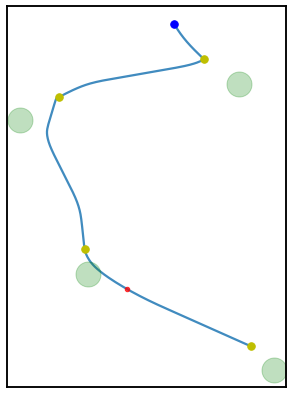

In [21]:
# Plot an encoding trial: with traversals, chest locations, and spike firing
plot_positions(t_pos, alpha=0.85, figsize=(5, 7))
ax = plt.gca()
ax.plot(*t_pos[:, 0], 'b.', ms=15)
[ax.plot(*cht, 'y.', ms=15) for cht in ch_times];
ax.plot(chest_xs[t_mask], chest_ys[t_mask], '.g', ms=50, alpha=0.25)
ax.plot(t_spike_xs, t_spike_ys, '.r', alpha=0.75,)

# Serial Position

In [22]:
# Get the length of time between segments (chest openings)
seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))

In [23]:
# Count firing in each segment, and compute firing rate
count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
count.update(np.digitize(t_spikes, ch_openings))
frs = np.array(list(count.values())) / seg_times

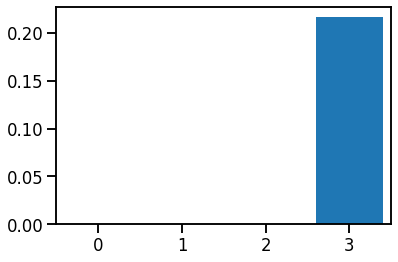

In [24]:
# Plot firing rate per segment (single trial)
plot_bar(frs, count.keys())

In [25]:
# Compute firing rates per segment for all trials
all_frs = compute_serial_position_fr(spikes, nav_starts, chest_openings, chest_trials, ptimes, positions)

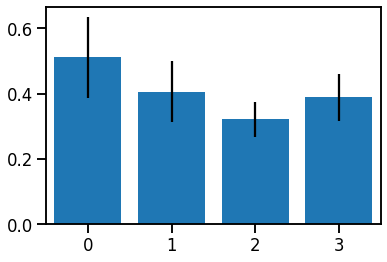

In [26]:
# Plot firing rates per segment across all trials
plot_bar(all_frs.mean(0), count.keys(), yerr=sem(all_frs, 0))

### Shuffle Analysis

In [27]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)

In [28]:
# compute the firing rate per segement across trials on surrogates
all_surrs = np.zeros(shape=[n_surrogates, 4])
for ind, stimes in enumerate(times_shuffle):
    
    # Get trial-level segment activity & take the mean firing rate per segment of each shuffle
    surrs_frs = compute_serial_position_fr(\
        stimes, nav_starts, chest_openings, chest_trials, ptimes, positions) 
    all_surrs[ind] = np.mean(surrs_frs, 0)

In [29]:
# Compute the empirical p-values and z-scores for each segment
surr_p_vals = [compute_empirical_pvalue(all_frs.mean(0)[ind], all_surrs[:, ind]) for ind in range(4)]
z_scores = [zscore_to_surrogates(all_frs.mean(0)[ind], all_surrs[:, ind]) for ind in range(4)]

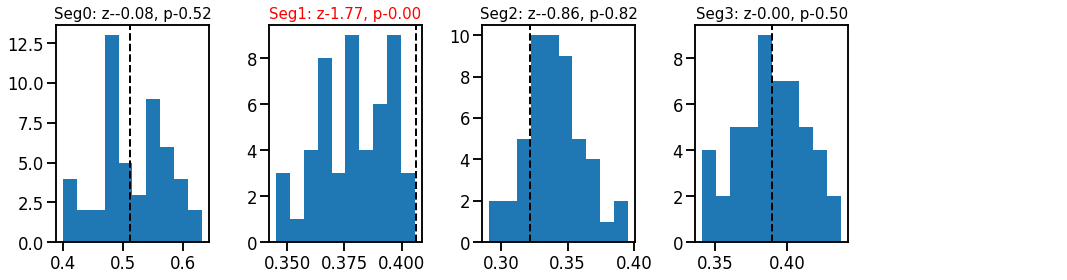

In [30]:
# Plot distribution of surrogates with measured empirical value for each segment (seg1, seg2, seg3, seg4)
for ii, ax in zip(range(4), make_axes(4, wspace=0.4)):
    plot_surrogates(all_surrs[:,ii], all_frs.mean(0)[ii], ax=ax)
    color = 'red' if surr_p_vals[ii] < 0.05 else 'black'
    title = 'Seg{}: z-{:1.2f}, p-{:1.2f}'.format(ii, z_scores[ii], surr_p_vals[ii])
    ax.set_title(title, fontdict={'fontsize' : 15}, color=color);

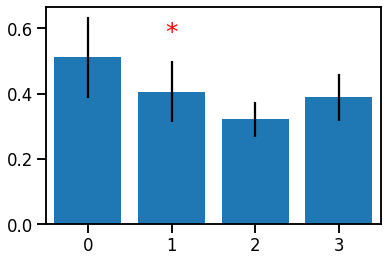

In [31]:
# Plot firing rates per segment across all trials, indicating shuffle significance
plot_bar(all_frs.mean(0), count.keys(), yerr=sem(all_frs, 0))
for ind, p_val in enumerate(surr_p_vals):
    if p_val < 0.05:
        ax=plt.gca()
        ax.text(ind, ax.get_ylim()[1]-0.15*ax.get_ylim()[1],
                '*', c='red', fontdict={'fontsize' : 25}, ha='center')

# All Cells

In [32]:
# # Plot the firing rate per segment across trials for all units 
# for ii, ax in zip(keep_inds, make_axes(n_keep, hspace=0.4, wspace=0.4)):

#     spikes = nwbfile.units.get_unit_spike_times(ii)
    
#     seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
        
#     # Count firing in each segment, and compute firing rate
#     count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
#     count.update(np.digitize(t_spikes, ch_openings))
#     frs = np.array(list(count.values())) / seg_times
    
#     all_frs = compute_serial_position_fr(\
#         spikes, nav_starts, chest_openings, chest_trials, ptimes, positions)
    
#     # Compute the firing rate per segement across trials on surrogates
#     times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)
#     all_surrs = np.zeros(shape=[n_surrogates, 4])
#     for ind, stimes in enumerate(times_shuffle):
            
#         # Get trial-level segment activity & take the mean firing rate per segment of each shuffle
#         surrs_frs = compute_serial_position_fr(\
#             stimes, nav_starts, chest_openings, chest_trials, ptimes, positions) 
#         all_surrs[ind] = np.mean(surrs_frs, 0)
                
#     # Compute the empirical p-values and z-scores for each segment
#     surr_p_vals = [compute_empirical_pvalue(all_frs.mean(0)[ind], all_surrs[:, ind]) for ind in range(4)]
#     z_scores = [zscore_to_surrogates(all_frs.mean(0)[ind], all_surrs[:, ind]) for ind in range(4)]
        
#     # Plot firing rates per segment across all trials, and indicate significance
#     plot_bar(all_frs.mean(0), count.keys(), yerr=sem(all_frs, 0), ax=ax)
#     title = 'U{}'.format(ii)
#     ax.set_title(title, fontdict={'fontsize' : 12})
#     for ind, p_val in enumerate(surr_p_vals):
#         if p_val < 0.05:
#             ax.text(ind, ax.get_ylim()[1]-0.15*ax.get_ylim()[1],
#                     '*', c='red', fontdict={'fontsize' : 25}, ha='center')